_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Coding Lab 5



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io

%matplotlib inline

plt.style.use("../matplotlib_style.txt")

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$L(\omega) = \ldots$

$\frac{dL(\omega)}{d\omega} = \ldots$

$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t)$$

We can decompose the multiplication terms into three parts as follows:

$$= \log \prod_t r_t^{c_t} \cdot \frac{1}{c_t!} \cdot \exp(-r_t)$$

We know that $\log(a.b) = \log(a) + \log(b)$, so we can write the above as follows:

$$= \sum_t (\log r_t^{c_t} + \log \frac{1}{c_t!} + \log \exp(-r_t))$$

Final answer for part one:

$$\boxed{L(w) = \sum_t (c_t \log r_t- \log c_t!  - r_t )}$$



For the part 2nd, we need to compute the gradient of the log-likelihood function with respect to $w$, i.e.,


$$\frac{dL(w)}{dw} = \frac{d}{dw} (\sum_t c_t \log r_t - \log c_t! - r_t) $$

One important note that the derivate of $c_t$ with respect to $dw$ is zero as $c_t$ depends on the distribution of $r_t$ and $r_t$ in turn depends on $w$ but derivative of $c_t$ with respect to $w$ is not the same as the derivative of the distribution of $c_t$ with respect to $w$. So, the derivative of $c_t$ with respect to w is zero, because $c_t$ is not a function of w, but a random variable that follows a Poisson distribution with parameter $r_t$. Hence, $\frac{dc}{dw} = 0$

$$\frac{dL(w)}{dw} = \sum_t c_t \frac{d}{dw} \log r_t - 0 + \frac{d}{dw} r_t $$

We can simplify the above as:

$$= \sum_t \left(\frac{c_t}{r_t} - 1\right) \frac{dr_t}{dw}$$ 

This can be simplified by using the relationship $r_t = \exp(w^T s_t) \Delta t R $ and the derivative of this will be given as $ \frac{dr_t}{dw} = s_t \exp(w^T s_t) \Delta t R$

$$= \sum_t \left(\frac{c_t}{(\exp(w^T s_t) \Delta t R} - 1\right)  s_t \exp(w^T s_t) \Delta t R $$ 

This, can be simplified as 

$$= \sum_t c_t s_t - \exp(w^T s_t) \Delta t R s_t $$ 

We know that $r_t = \exp(w^T s_t) \Delta t R$, hence we can simplify the above as 


$$\boxed{\frac{dL(w)}{dw}= \sum_t (c_t - r_t) s_t} $$ 



### Generate data

Text(0.5, 1.0, 'Gaussian RF')

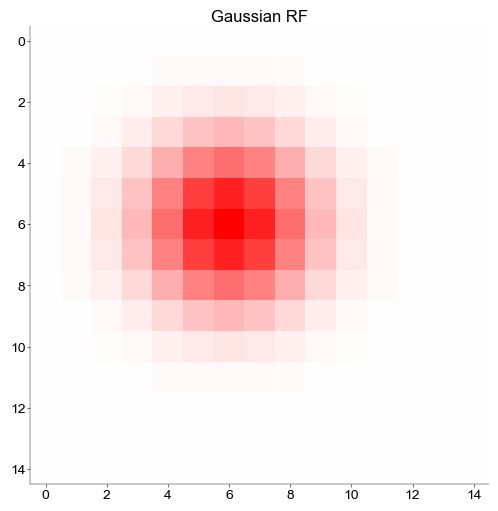

In [2]:
def gen_gauss_rf(D, width, center=(0,0)):
    
    sz = (D-1)/2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w

w = gen_gauss_rf(15,7,(1,1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(w, cmap='bwr', vmin=-vlim, vmax=vlim)
ax.set_title('Gaussian RF')

In [3]:
def sample_lnp(w, nT, dt, R, v):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the stimulus

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    np.random.seed(10)

    # insert your code here
    from scipy import stats

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (0.5 pts)
    # ------------------------------------------------
    from sklearn.datasets import make_checkerboard
    
    s = stats.norm(scale=np.sqrt(v)).rvs(size=(w.shape[0], nT))
    
    r = np.exp(w.T@s) * dt * R
    
    c = np.random.poisson(r)
    
    
    return c, r, s


In [4]:
D = 15     # number of pixels
nT = 1000  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      # stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, v)

Plot the responses of the cell.

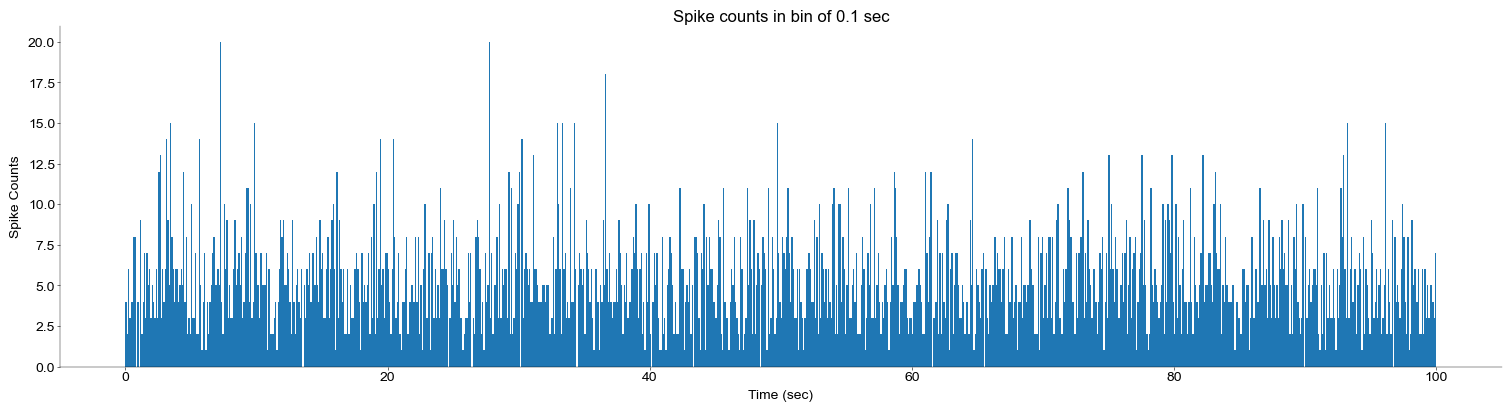

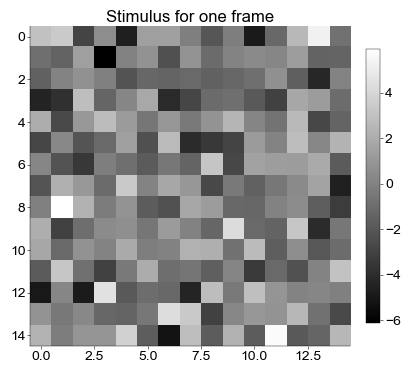

In [5]:
mosaic = [["Spike counts in bin of 0.1 sec"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15,4))
# --------------------------------------
# Plot the cell's responses (0.5 points)
# --------------------------------------

time = np.arange(dt/2, nT*dt, dt) # start from dt/2 and increment by dt until 1000*dt

ax[mosaic[0][0]].bar(time, c, width=dt, align='center')

ax[mosaic[0][0]].set_xlabel("Time (sec)")
ax[mosaic[0][0]].set_ylabel("Spike Counts")
ax[mosaic[0][0]].set_title(mosaic[0][0])


# plot the stimulus grid only for one frame
mosaic = [['Stimulus for one frame']]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(4,4))

img = ax[mosaic[0][0]].imshow(s[:,0].reshape((15,15)), cmap='gray')
ax[mosaic[0][0]].set_title(mosaic[0][0])
fig.colorbar(img, ax=ax[mosaic[0][0]], location='right',  shrink=0.7)


### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [6]:
def negloglike_lnp(x, c, s, dt=0.1, R=50):
    '''Implements the negative (!) log-likelihood of the LNP model and its
    gradient with respect to the receptive field w.

    Parameters
    ----------

    x: np.array, (Dx * Dy, )
      current receptive field 

    c: np.array, (nT, )
      spike counts 

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at x
    
    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to x 
    '''

    # insert your code here 

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # and its gradient with respect to the receptive
    # field `w` using the simplified equantions you
    # calculated earlier. (0.5 pts)
    # ------------------------------------------------
    
    from scipy.special import factorial,gammaln, expit
        
    #r = np.exp(x.T@s) * dt * R
    # TO avoid overflow
    r = expit(np.dot(x.T,s)) * dt * R
     
    # To the code more efficient and avoid numerical overflow, we are using gamma function
    # f = -np.sum(c*np.log(r) - np.log(factorial(c)) - r) 
    
    f = -np.sum(c * np.log(r) - r - gammaln(c+1))
        
    df = -(c - r)@s.T

    return f, df


Fit receptive field maximizing the log likelihood

In [7]:
# insert your code here 

# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly, 
# minimizing the negative log-likelihood).
# 
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------

import scipy
from scipy.optimize import minimize, check_grad

negloglik = lambda x: negloglike_lnp(x,c,s)[0]
grad_negloglik = lambda x: negloglike_lnp(x,c,s)[1]

error = check_grad(negloglik,grad_negloglik, w) # To check if gradient is calculated is right

print("The error using check_grad function is {} for the actual receptive field w".format(error))


x0= w #scipy.stats.norm.rvs(size=(D, D)).flatten() #np.random.randn(225) #inititalizing the values for receptive field
w_cal = minimize(negloglik, x0 ,jac=grad_negloglik, method='BFGS')
w_opt = w_cal.x

The error using check_grad function is 3054.7208344832425 for the actual receptive field w


Text(0.5, 1.0, 'Estimated')

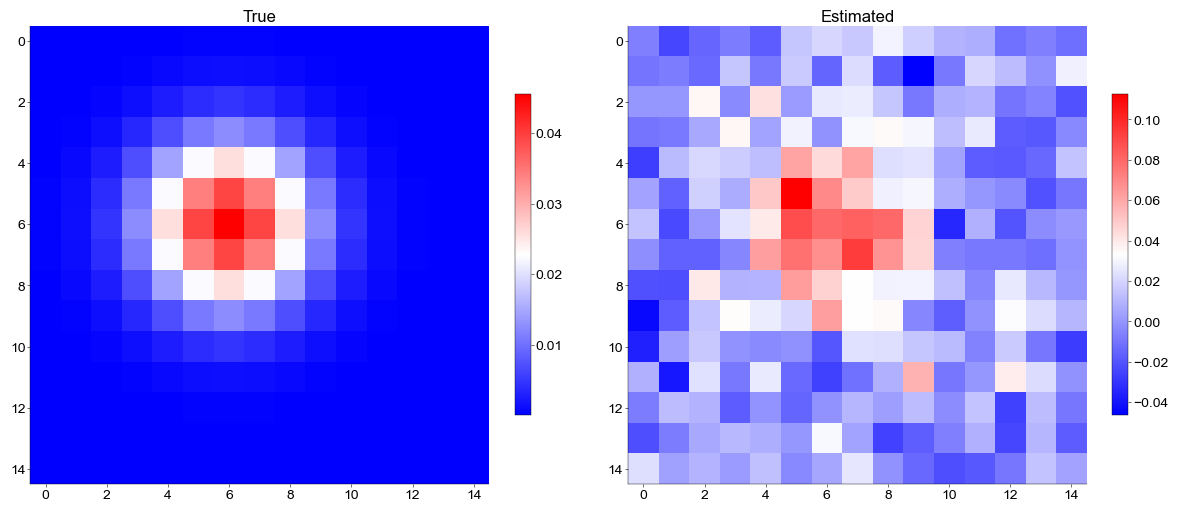

In [8]:
# insert your code here 

# ------------------------------------
# Plot the ground truth and estimated 
# `w` side by side. (0.5 pts)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12,5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

img = ax[mosaic[0][0]].imshow(w.reshape((15,15)), cmap='bwr')
fig.colorbar(img, ax=ax[mosaic[0][0]], location='right',  shrink=0.7)
ax[mosaic[0][0]].set_title(mosaic[0][0])


img = ax[mosaic[0][1]].imshow(w_opt.reshape((15,15)), cmap='bwr')
fig.colorbar(img, ax=ax[mosaic[0][1]], location='right',  shrink=0.7)
ax[mosaic[0][1]].set_title(mosaic[0][1])



In [9]:
%%time
# insert your code here 

# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly, 
# minimizing the negative log-likelihood).
# 
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------
from scipy import stats
def estimate_receptive_field(w0, counts, stim, dt=0.1, R=50):
    f = lambda w: negloglike_lnp(w, counts, stim, dt, R)[0]
    df = lambda w: negloglike_lnp(w, counts, stim, dt, R)[1]
    res = opt.minimize(f, w0, jac=df, method='BFGS')
    return res.x

nT = 10000
w = gen_gauss_rf(D, 7, (1, 1))
c, r, s = sample_lnp(w.flatten(), nT, dt, R, v)

w0 = gen_gauss_rf(D,7,(0, 0)).flatten()
w_hat = estimate_receptive_field(w0, c, s)

CPU times: total: 2.19 s
Wall time: 729 ms


<timed exec>:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
<timed exec>:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
<timed exec>:14: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.


CPU times: total: 19.7 s
Wall time: 5.74 s


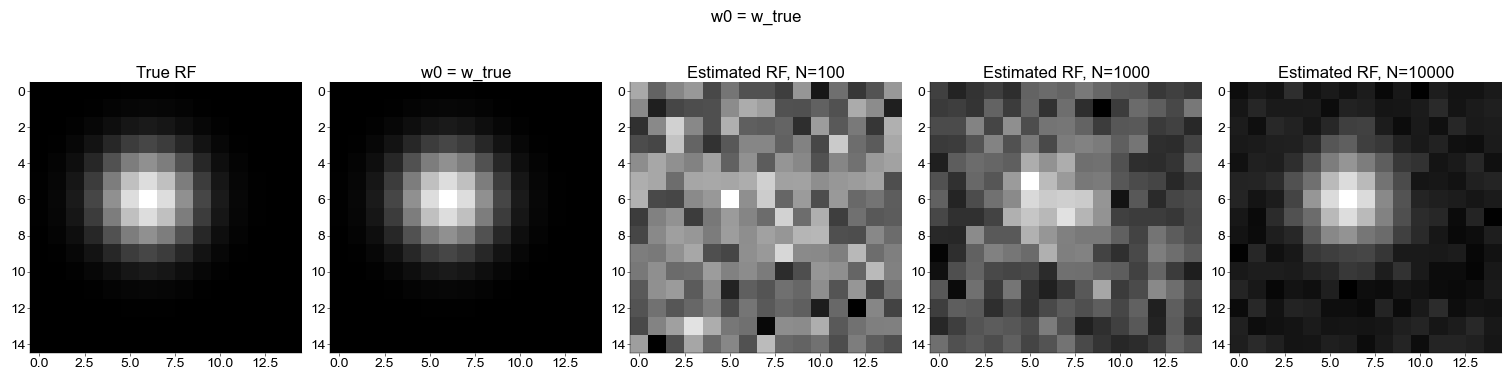

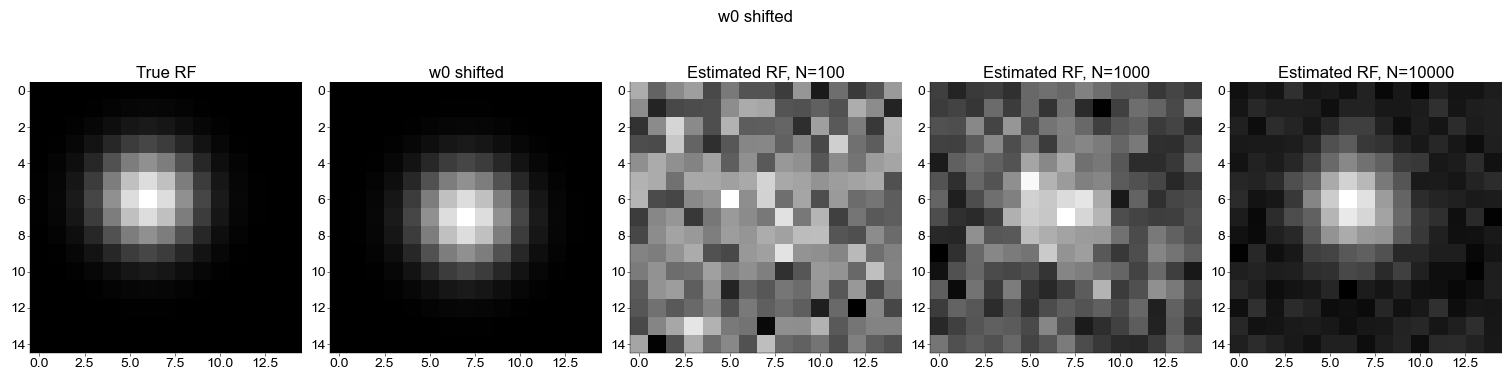

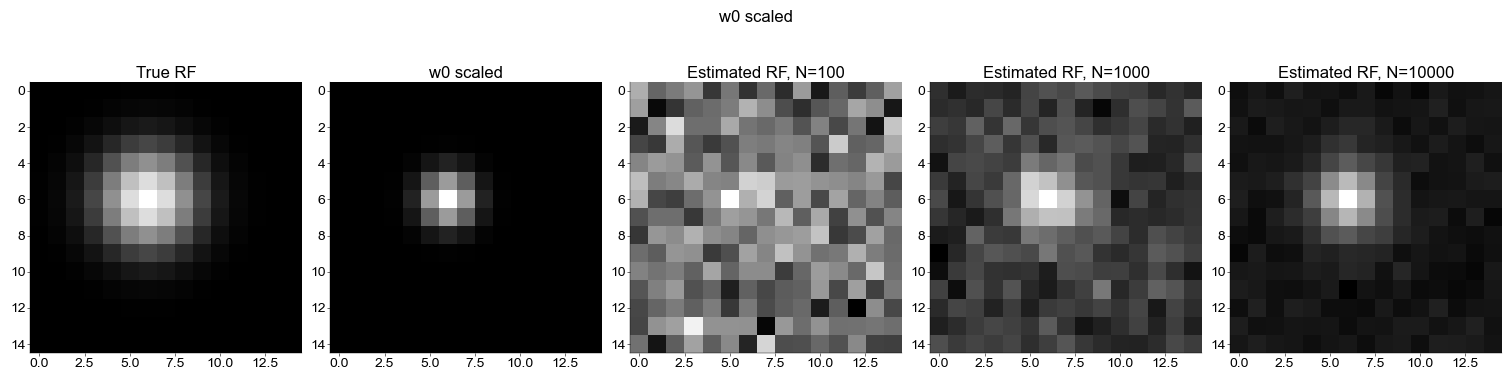

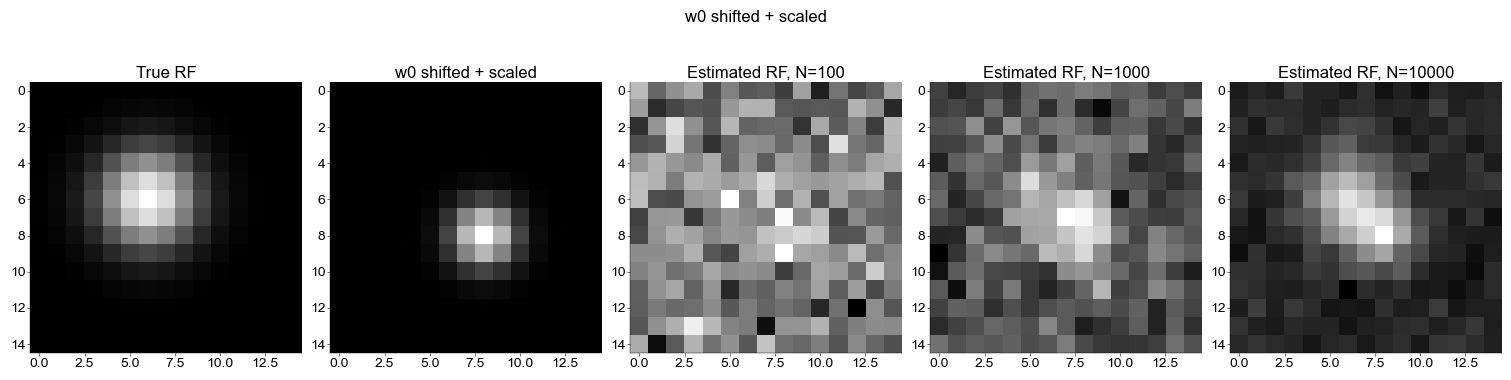

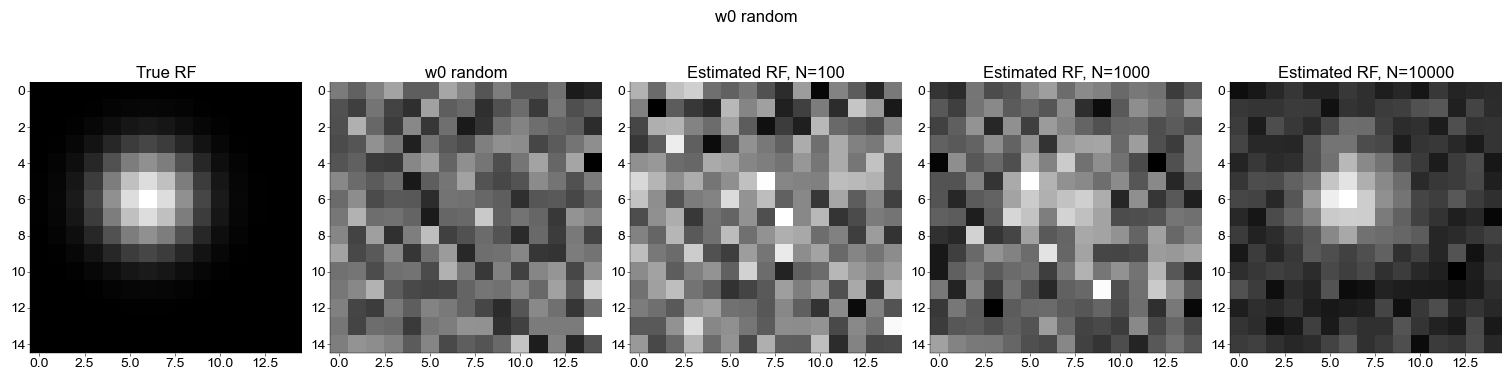

In [10]:
%%time

np.random.seed(42)

# different intializations
w0_labels = ["w0 = w_true", 
             "w0 shifted", 
             "w0 scaled", 
             "w0 shifted + scaled", 
             "w0 random"]

w0_list = [gen_gauss_rf(D, 7, (1, 1)).flatten(), 
           gen_gauss_rf(D, 7, (0, 0)).flatten(), 
           gen_gauss_rf(D, 2, (1, 1)).flatten(), 
           gen_gauss_rf(D, 3, (-1, -1)).flatten(), 
           stats.norm.rvs(size=(D, D))]

for w0, w0_label in zip(w0_list, w0_labels):
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 5, 1)
    plt.imshow(w.reshape((D, D)), cmap='gray')
    plt.title(f"True RF")
    
    plt.subplot(1, 5, 2)
    plt.imshow(w0.reshape((D, D)), cmap='gray')
    plt.title(w0_label)
    
    for i, nT in enumerate([100, 1000, 10000]):

        c, r, s = sample_lnp(w.flatten(), nT, dt, R, v)
        w_hat = estimate_receptive_field(w0, c, s)

        plt.subplot(1, 5, i + 3)
        plt.imshow(w_hat.reshape((D, D)), cmap='gray')
        plt.title(f"Estimated RF, N={nT}")
       
    plt.suptitle(w0_label)

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [11]:
var = io.loadmat('../data/nds_cl_5_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s = var['DN_stim']
s = s.reshape((300,1500)) # the shape of each frame is (20, 15)
s = s[:,1:len(trigger)]

In [12]:
t.shape, trigger.shape, s.shape

((5500,), (1489,), (300, 1488))

Create vector of spike counts

Text(0, 0.5, 'Spike Counts')

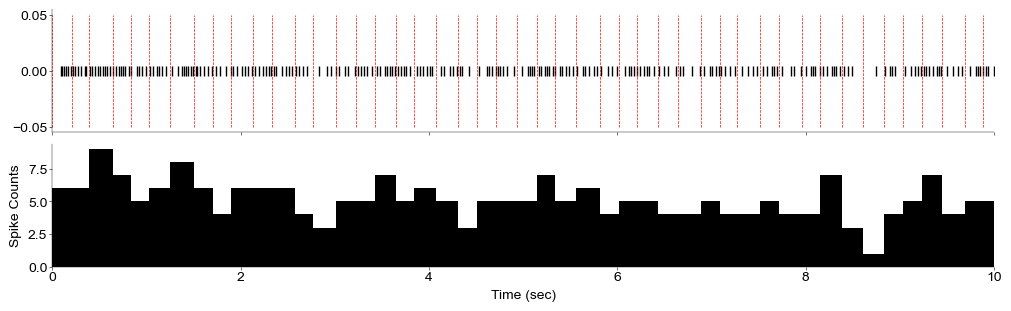

In [13]:
# insert your code here 

# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------
counts, bin_edge = np.histogram(t,bins=trigger)

fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

ax = axes[0]
ax.vlines(trigger, -0.05, 0.05, color='red', linewidth=0.5, linestyle='--')
ax.scatter(t, np.zeros(len(t)), s=50, marker='|', facecolor='black')

ax = axes[1]
ax.bar(bin_edge[:-1] + np.diff(bin_edge) / 2, counts, np.diff(bin_edge), color='black')
ax.set_xlim((0, 10))
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Spike Counts")

Fit receptive field for each frame separately

In [14]:
def w_intialization(Dx, Dy, width, center=(0,0)):
    
    sx = (Dx-1)/2
    sy = (Dy-1)/2
    x, y = np.meshgrid(np.arange(-sx, sx + 1), np.arange(-sy, sy + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w


In [15]:
# insert your code here 

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
# 
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]
dt = np.diff(bin_edge)
Dx, Dy = 20, 15
w_hat  = np.empty(shape=(Dx*Dy,5))

# fit for each delay

for i, delay in enumerate(delta):
    w0 = w_intialization(20,15,5,(0,0))    #stats.norm.rvs(size=(Dx, Dy))
    count_shifted = np.roll(counts, -delay)
    
    # Store the optimal w in w_hat
    w_hat[:, i] = estimate_receptive_field(w0.flatten(), count_shifted, s, dt=dt, R=50)
  

Plot the frames one by one

Text(0.5, 0.98, 'Receptive field for different delays')

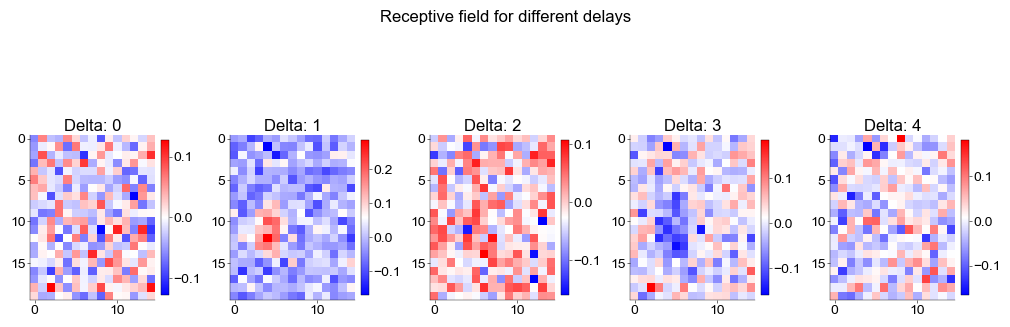

In [16]:
# insert your code here 

# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True)

for i, axs in enumerate(ax):
    val = delta[i]
    img = ax[val].imshow(w_hat[:,i].reshape((Dx,Dy)), cmap='bwr')
    fraction = 0.047 * (Dx / Dy)
    plt.colorbar(img, ax=ax[val], fraction=fraction)
    ax[val].set_title('Delta: {}'.format(val))
    
fig.suptitle("Receptive field for different delays")


## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

Text(0.5, 1.0, 'First spatial Component in image form')

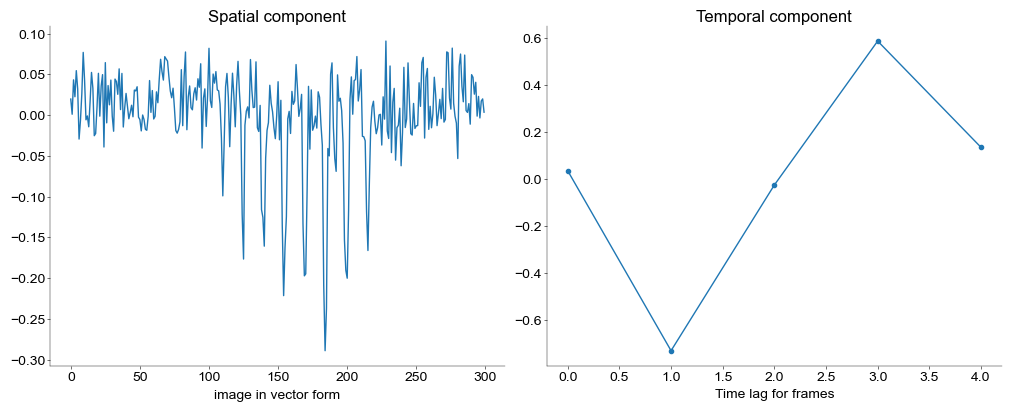

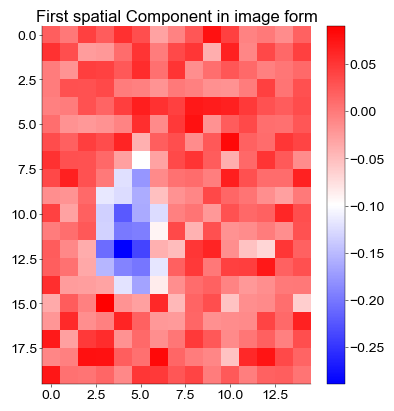

In [18]:
# insert your code here 

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------


# shape of w_hat: (300,5). 
# subtract mean along axis=1 (time) since for every timelag the RF is estimated independently

w_hat_mean = np.mean(w_hat, axis=1)
w_hat_centered = w_hat - w_hat_mean[:, np.newaxis]

spatial, eigen, temporal = np.linalg.svd(w_hat_centered)

# First component is given as u[:,0]*s[0]*v[0,:]
temp_comp = eigen[0] * temporal[0,:] # Need to scale temporal with the eigen value as otherwise it is normlaized to unit vector
spatial_comp = spatial[:, 0] # Already scaled

# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[['Spatial', 'Temporal']], figsize=(10,4), constrained_layout=True)
# add plot


ax['Spatial'].plot(spatial_comp)
ax['Spatial'].set_xlabel("image in vector form")
ax['Spatial'].set_title("Spatial component")


ax['Temporal'].plot(temp_comp)
ax['Temporal'].scatter(range(len(temp_comp)),temp_comp)
ax['Temporal'].set_xlabel("Time lag for frames")
ax['Temporal'].set_title("Temporal component")


plt.figure(figsize=(4,4))
img = plt.imshow(spatial_comp.reshape((Dx,Dy)), cmap='bwr')
plt.colorbar(img)
plt.title("First spatial Component in image form")

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [19]:
from sklearn import linear_model

# insert your code here 

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before) 
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
alpha_list = [0.0001, 0.001, 0.01, 0.1, 1]


dt = np.diff(bin_edge)
Dx, Dy = 20, 15
w_hat_lasso  = np.empty(shape=(Dx*Dy,len(alpha_list),5))


# fit for each delay
for j, alpha in enumerate(alpha_list):
    for i, delay in enumerate(delta):
        w0 = w_intialization(20,15,5,(0,0))
        count_shifted = np.roll(counts, -delay)
        
        model = linear_model.Lasso(alpha=alpha, random_state=0)
        model.fit(s.T, count_shifted)
        
        # Store the optimal w in w_hat
        w_hat_lasso[:,j, i] = model.coef_
    

Text(0.5, 0.98, 'Without LASSO: receptive field for different delays')

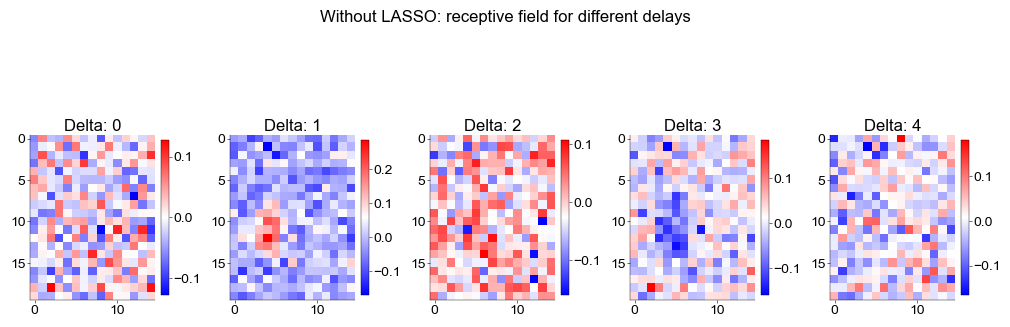

In [27]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True)
# add plot

for i, axs in enumerate(ax):
    val = delta[i]
    img = ax[val].imshow(w_hat[:,i].reshape((Dx,Dy)), cmap='bwr')
    fraction = 0.047 * (Dx / Dy)
    plt.colorbar(img, ax=ax[val], fraction=fraction)
    ax[val].set_title('Delta: {}'.format(val))
    
fig.suptitle("Without LASSO: receptive field for different delays")


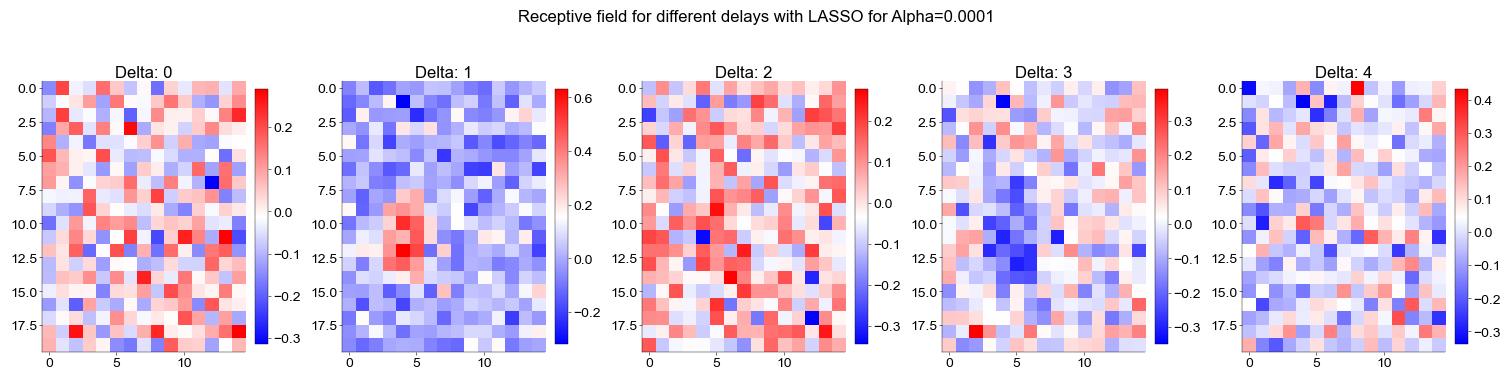

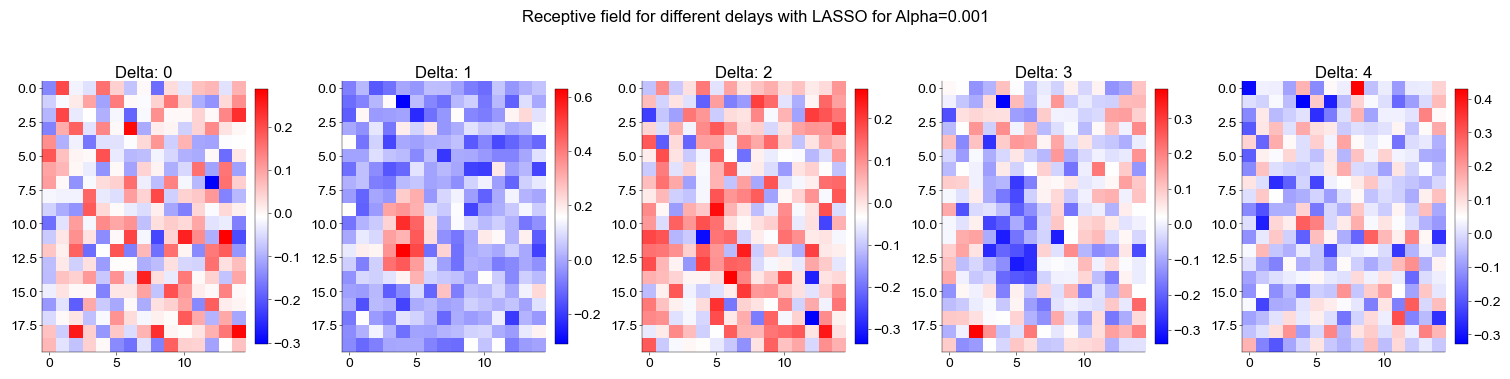

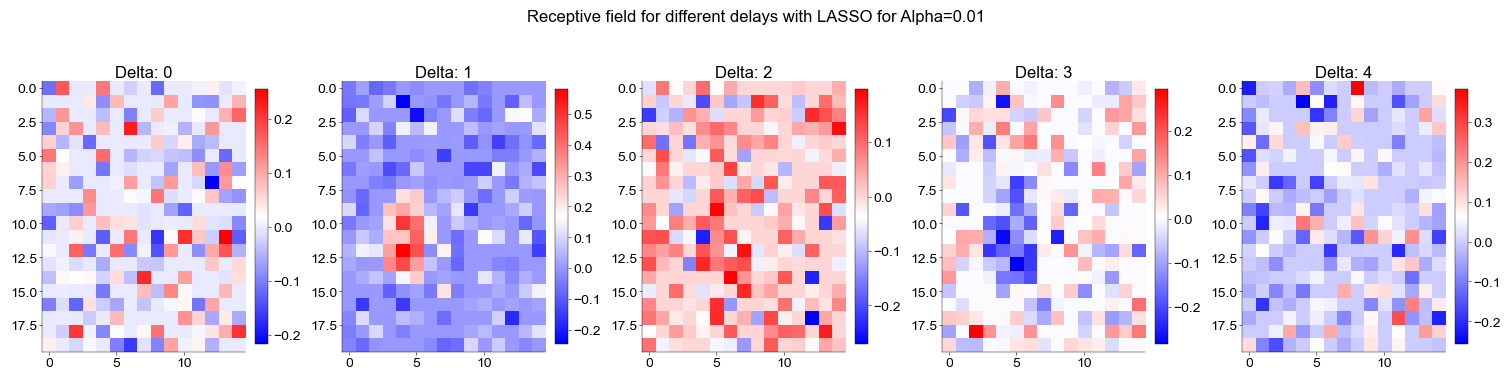

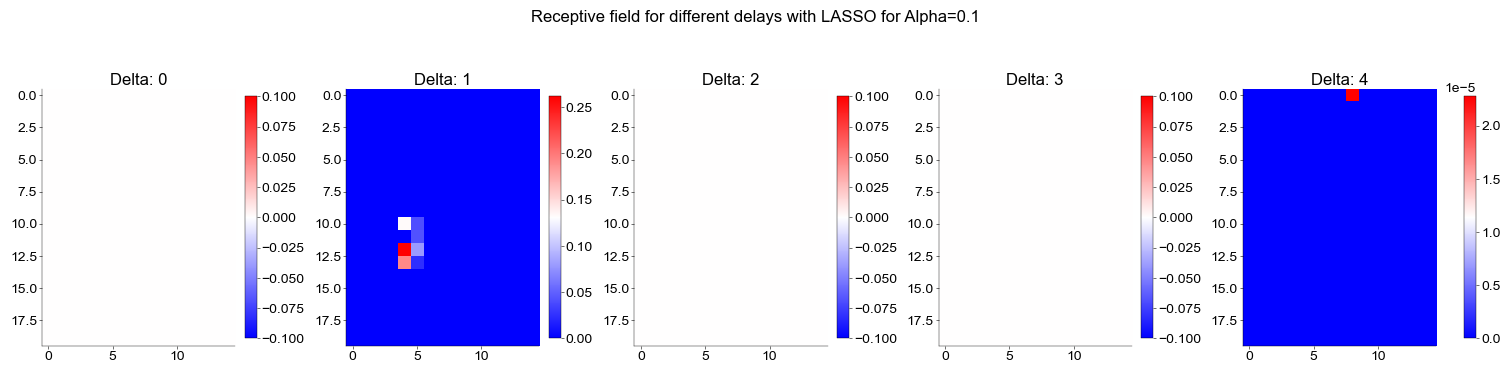

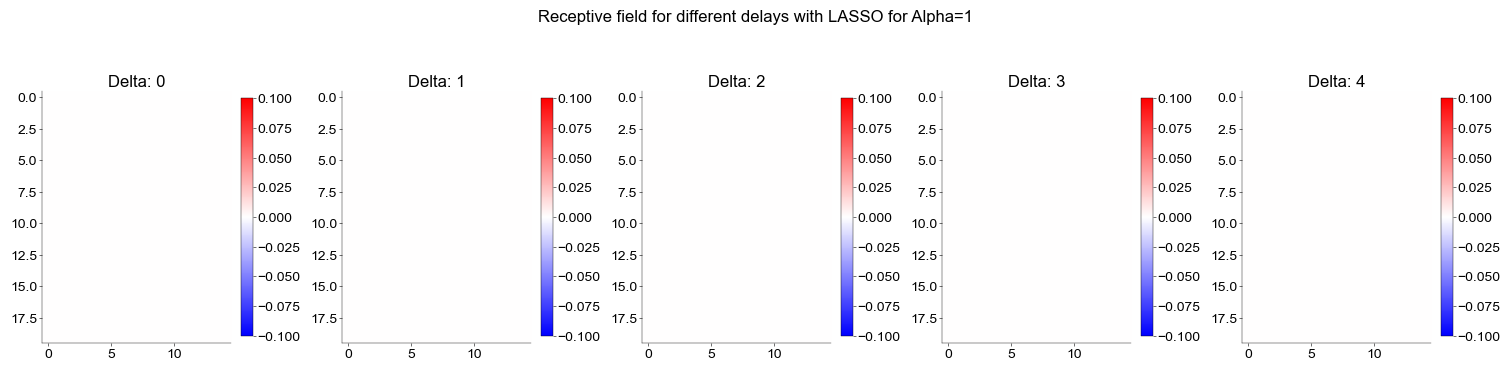

In [28]:
for j, alpha in enumerate(alpha_list):
    
    plt.figure(figsize=(15, 4))

    for i, delay in enumerate(delta):
        
        plt.subplot(1, 5, i+1)
        img = plt.imshow(w_hat_lasso[:,j,i].reshape((Dx, Dy)), cmap='bwr')
        fraction = 0.047 * (Dx / Dy)
        plt.colorbar(img, fraction=fraction)
        plt.title("Delta: {}".format(delay))
       
    plt.suptitle('Receptive field for different delays with LASSO for Alpha={}'.format(alpha))
    